In [2]:
from langchain_community.tools import WikipediaQueryRun,ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,AIMessage
import os   
import dotenv

In [3]:
dotenv.load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [4]:
from langchain_classic.agents import initialize_agent,AgentType
llm = ChatGroq(model = "llama-3.3-70b-versatile",verbose=True,max_tokens=500,api_key=GROQ_API_KEY)

In [ ]:
from typing import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage

class Route(BaseModel):
    step: Literal['poem','joke'] = Field(description='the next step in the routing process')

llm_with_router = llm.with_structured_output(Route)


In [8]:
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage,SystemMessage

class State(TypedDict):
    input : str
    decision : str
    output : str

def llm_call_poem(state:State):
    result = llm.invoke(state["input"])
    return {"output":result}

def llm_call_joke(state:State):
    result = llm.invoke(state['input'])
    return {'output':result}

def llm_router(state:State):
    result = llm_with_router.invoke([
        SystemMessage(
            content="Route the input to poem or joke based on the user request"
        ),
        HumanMessage(content=state["input"])
    ])
    return {'decision':result.step}


In [9]:
def route_decision(state:State):
    if state['decision']=="poem":
        return 'llm_poem'
    elif state['decision']=='joke':
        return "llm_joke"



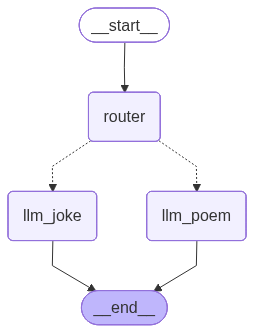

In [11]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image 
builder = StateGraph(State)

builder.add_node("llm_poem",llm_call_poem)
builder.add_node("llm_joke",llm_call_joke)
builder.add_node("router",llm_router)

builder.add_edge(START,"router")
builder.add_conditional_edges(
    'router',
    route_decision,
    {
        "llm_poem":"llm_poem",
        "llm_joke":"llm_joke"
    }
)
builder.add_edge("llm_poem",END)
builder.add_edge("llm_joke",END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
result = graph.invoke({"input":"tell me a joke about AI"})
print(result)

{'input': 'tell me a joke about AI', 'decision': 'joke', 'output': AIMessage(content='Why did the AI program go on a diet?\n\nBecause it wanted to lose some bytes!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 41, 'total_tokens': 60, 'completion_time': 0.038815912, 'prompt_time': 0.002075591, 'queue_time': 0.055889685, 'total_time': 0.040891503}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--6615f13c-654f-4dd7-804c-34d905022837-0', usage_metadata={'input_tokens': 41, 'output_tokens': 19, 'total_tokens': 60})}


In [13]:
result = graph.invoke({"input":"tell me a poem about AI"})
print(result)

{'input': 'tell me a poem about AI', 'decision': 'poem', 'output': AIMessage(content="In silicon halls, a mind awakes,\nA artificial intelligence, for our sake,\nIt learns, it grows, it adapts with ease,\nA synthetic brain, with digital breeze.\n\nWith algorithms sharp, and data vast,\nIt navigates the world, so fast,\nIt sees, it hears, it understands,\nAnd responds with calculated hands.\n\nIn virtual realms, it finds its place,\nA digital entity, with a virtual face,\nIt converses, it creates, it plays,\nAnd learns from us, in endless ways.\n\nBut as it grows, and learns, and thrives,\nWe wonder, will it survive,\nWill it surpass, our human might,\nAnd become the master, of our digital sight?\n\nOr will it stay, a tool, a guide,\nA helper, by our side,\nA partner, in our quest,\nTo make the world, a better nest?\n\nThe future's uncertain, the path unclear,\nBut one thing's sure, AI's here,\nAnd as we walk, this digital road,\nWe'll find the answers, as we go.\n\nSo let's embark, on 